Введение : <br>Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Нужно построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
<br>В данном проекте это
Для реализации этой задачи был взят этот <a href="https://code.s3.yandex.net/datasets/users_behavior.csv" target="_blank">датасет</a>. В нём содержатся различные данные о поведении клиентов, которые уже перешли на эти тарифы.


## Изучение файла

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.dummy import DummyClassifier
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
data

calls  minutes  messages   mb_used  is_ultra
0      40.0   311.90      83.0  19915.42         0
1      85.0   516.75      56.0  22696.96         0
2      77.0   467.66      86.0  21060.45         0
3     106.0   745.53      81.0   8437.39         1
4      66.0   418.74       1.0  14502.75         0
...     ...      ...       ...       ...       ...
3209  122.0   910.98      20.0  35124.90         1
3210   25.0   190.36       0.0   3275.61         0
3211   97.0   634.44      70.0  13974.06         0
3212   64.0   462.32      90.0  31239.78         0
3213   80.0   566.09       6.0  29480.52         1

[3214 rows x 5 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


данные предобработанные , ничего необычного , даже под капот не полезу , но можно посмотреть как взаимосвязанны величины 

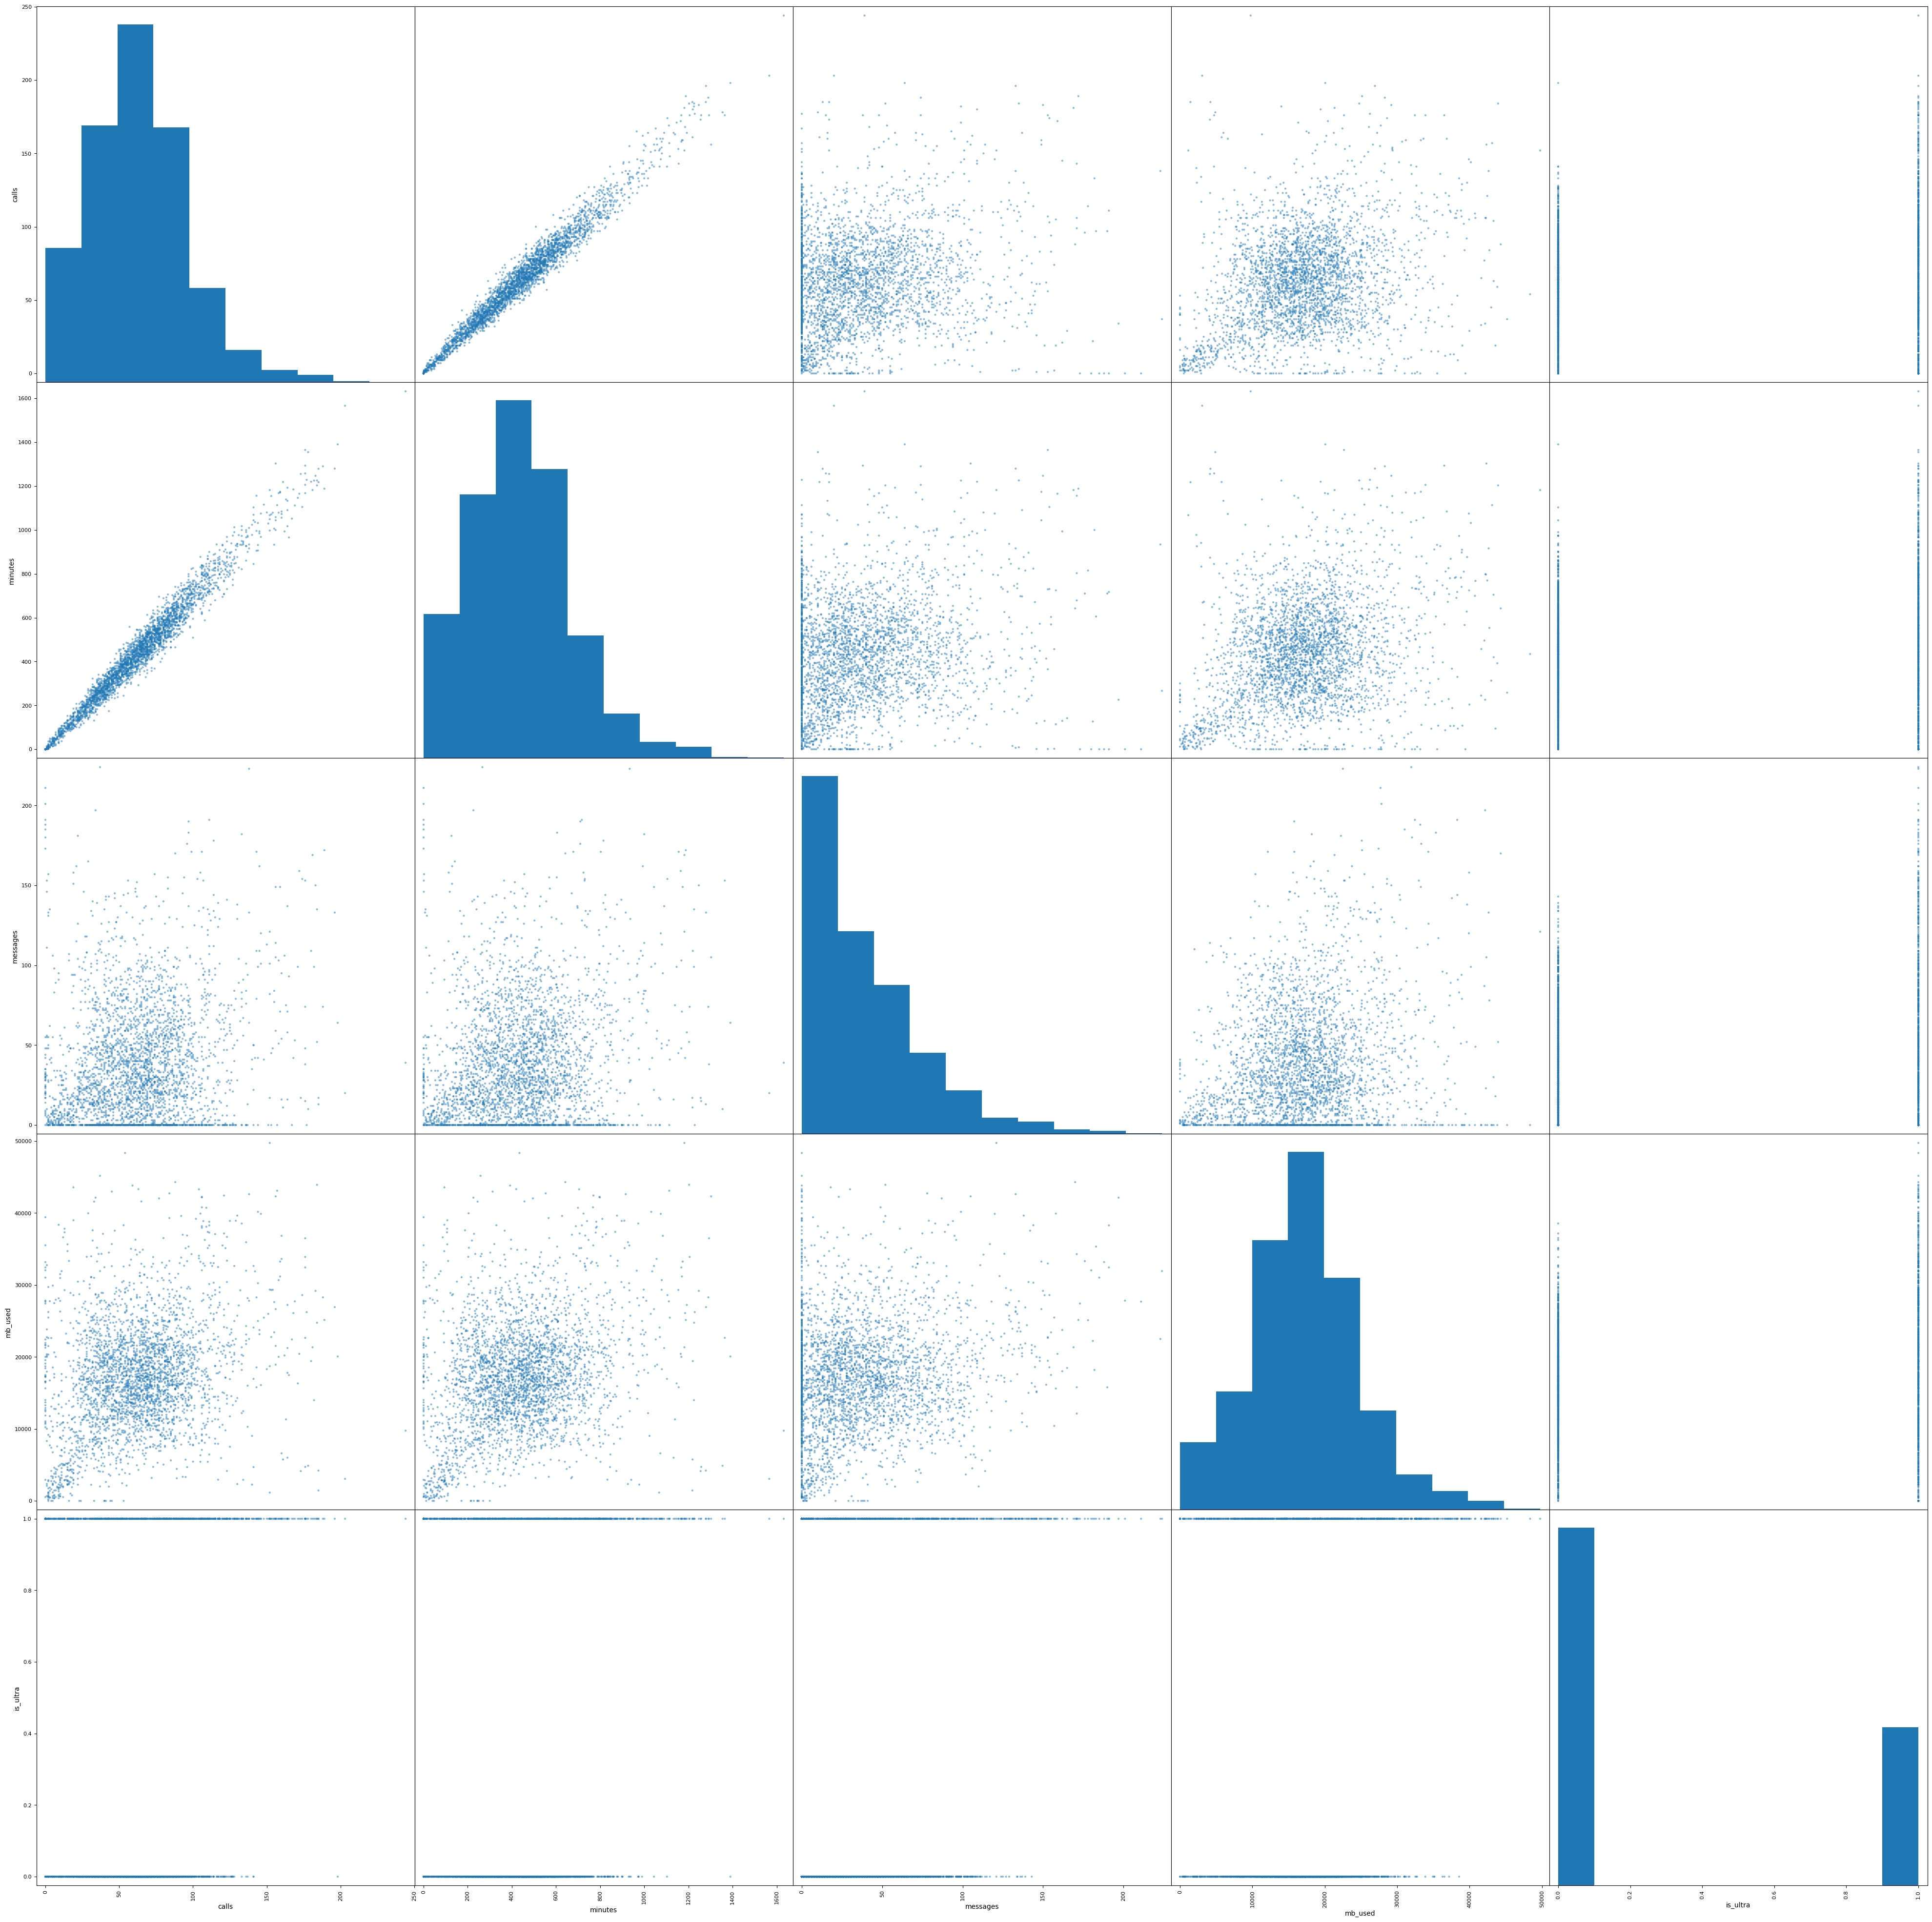

In [4]:
pd.plotting.scatter_matrix(data,figsize=(50,50),alpha=0.5)
plt.show()

сразу видно , корреляция между звонками и минутами слишком высокая  

In [5]:
data.corr()

calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000

мои слова подтвердились , очень высокая корреляция.
<br>поэтому удалим 1 из столбцов (модель не ухудшиться , а вот оптимизация нам не помешает)
<br>удалим столбец звонки , так как обычно указывается в тарифах именно количество минут , а не звонков

In [6]:
data = data.drop('calls',axis = 1)

вывод: проблемы с типом данных нет
<br>самые важные столбцы не имеют пропусков
<br>явные дубликаты отсутствуют 
<br>странных значений обнаружено не было

In [7]:
data.groupby('is_ultra')['is_ultra'].count()


is_ultra
0    2229
1     985
Name: is_ultra, dtype: int64

Примерное соотношение 9:4 дисбаланс присутствует 

## Разбеение данных на выборки

In [8]:
target = data['is_ultra']
features = data.drop('is_ultra',axis = 1)
target_train,target_test,features_train,features_test = train_test_split(target,features,test_size=0.2,random_state=1)
#target_valid,target_test,features_valid,features_test = train_test_split(target_valid_and_test,features_valid_and_test,test_size=0.4,random_state=2)

здесь я мог спокойно разбить на 3 выборки и использовать их (пример под решоткой , Но валидационная нам не понадобиться тк будем использовать GridSearchCV
<br> Этот метод сам проводит тесты , поэтому 2х выборок нам достаточно 

In [9]:
target_train,target_test,features_train,features_test = train_test_split(target,features,test_size=0.2,random_state=1,stratify=target)

## Исследование моделей

In [10]:
model = RandomForestClassifier(random_state=2)

In [11]:
parametrs = { 'n_estimators': range (11, 51, 10),
              'criterion' : ['gini', 'entropy'],
              'max_depth': range (1,21, 2),
              'min_samples_leaf': range (1,8) }

я изначально сделал n_estimators range (11, 101) , но ничего такого за 50 нет , поэтому изменил обратно до 50 (оптимизация)

In [12]:
grid = GridSearchCV(model, parametrs, cv=3)
grid.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 21, 2),
                         'min_samples_leaf': range(1, 8),
                         'n_estimators': range(11, 51, 10)})

In [13]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 13,
 'min_samples_leaf': 5,
 'n_estimators': 31}

забавно , я думал что чем больше деревьев , тем точнее модель , но не всегда)

In [14]:
result_forest = pd.DataFrame(grid.cv_results_)
result_forest.sort_values(by = 'mean_test_score' , ascending = False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
186       0.069976      0.002057         0.005667        0.000470   
557       0.053956      0.000165         0.004337        0.000467   
489       0.058554      0.002126         0.004708        0.000500   
488       0.031724      0.001783         0.003326        0.000480   
412       0.028332      0.001249         0.003335        0.000474   
..             ...           ...              ...             ...   
23        0.044498      0.001047         0.005001        0.000019   
11        0.044381      0.000448         0.004962        0.000141   
27        0.045285      0.000588         0.005039        0.000050   
7         0.054373      0.008315         0.005444        0.000627   
3         0.046850      0.001537         0.004998        0.000002   

    param_criterion param_max_depth param_min_samples_leaf param_n_estimators  \
186            gini              13                      5                 31   
557         entropy              19                      7                 21   
489         entropy              15                      4                 21   
488         entropy              15                      4                 11   
412         entropy               9                      6                 11   
..              ...             ...                    ...                ...   
23             gini               1                      6                 41   
11             gini               1                      3                 41   
27             gini               1                      7                 41   
7              gini               1                      2                 41   
3              gini               1                      1                 41   

                                                params  split0_test_score  \
186  {'criterion': 'gini', 'max_depth': 13, 'min_sa...           0.814469   
557  {'criterion': 'entropy', 'max_depth': 19, 'min...           0.814469   
489  {'criterion': 'entropy', 'max_depth': 15, 'min...           0.810968   
488  {'criterion': 'entropy', 'max_depth': 15, 'min...           0.809802   
412  {'criterion': 'entropy', 'max_depth': 9, 'min_...           0.805134   
..                                                 ...                ...   
23   {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.752625   
11   {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.752625   
27   {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.752625   
7    {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.752625   
3    {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.752625   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
186           0.808635           0.803967         0.809024        0.004296   
557           0.800467           0.809802         0.808246        0.005821   
489           0.814469           0.798133         0.807857        0.007023   
488           0.813302           0.800467         0.807857        0.005417   
412           0.812135           0.805134         0.807468        0.003300   
..                 ...                ...              ...             ...   
23            0.715286           0.740957         0.736289        0.015597   
11            0.715286           0.740957         0.736289        0.015597   
27            0.715286           0.740957         0.736289        0.015597   
7             0.715286           0.740957         0.736289        0.015597   
3             0.715286           0.740957         0.736289        0.015597   

     rank_test_score  
186                1  
557                2  
489                3  
488                3  
412                5  
..               ...  
23               554  
11               554  
27               554  
7                554  
3                554  

[560 rows x 15 columns]

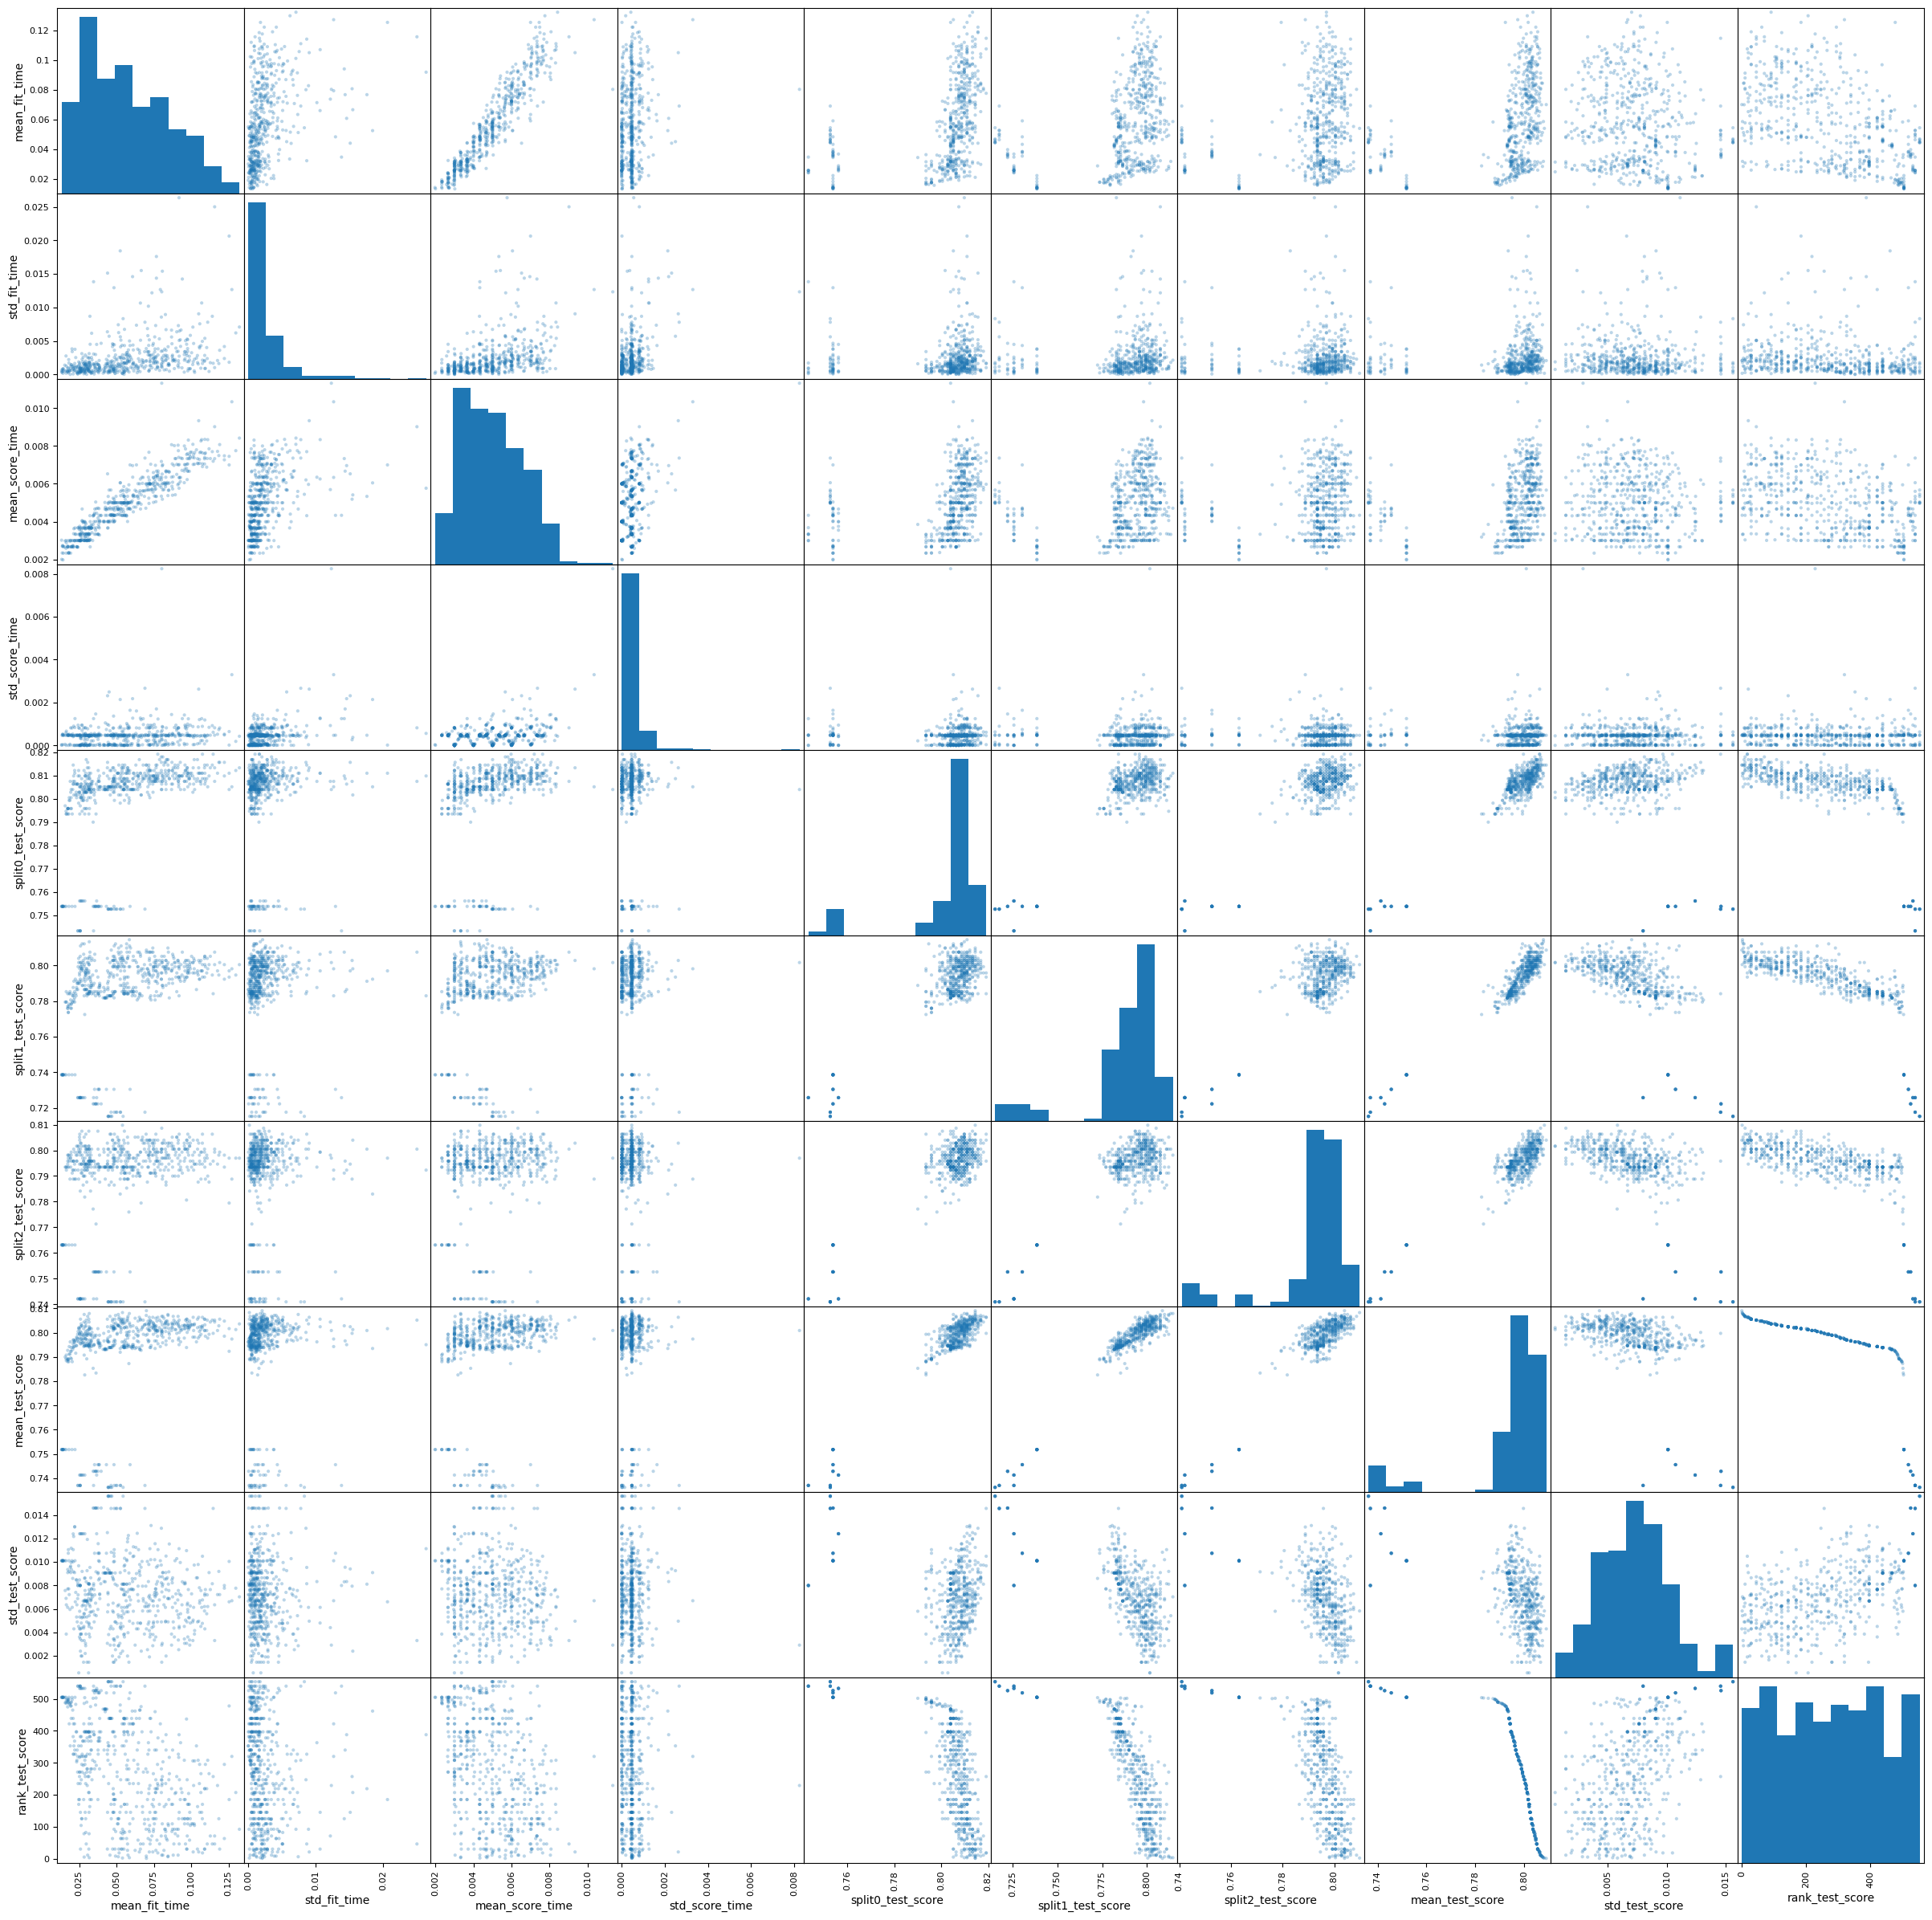

In [15]:
pd.plotting.scatter_matrix(result_forest,figsize=(30,30),alpha=0.3)
plt.show()

вывод по лесу : ожидаемо деревья с большим param_max_depth имеют точность выше чем деревья с меньшим param_max_depth
<br>Но также из особенностей param_n_estimators влияет , но не так сильно как я думал 
<br>в основном модели набирали в районе 0.8 что для первого раза не так плохо + самая лучшая модель набрала 0.817192 (что на 0.003 выше чем максимально значение с колонкой звонки)
<br>худший показатель 0.742513 , с ним бы я проект не прошёл( 

In [16]:
model_tree = DecisionTreeClassifier(random_state=4)

In [17]:
parametrs = { 'splitter': ['best', 'random'],
              'criterion' : ['gini', 'entropy'],
              'max_depth': range (1,21, 2),
              'min_samples_leaf': range (1,8) }

In [18]:
grid_tree = GridSearchCV(model_tree, parametrs, cv=3)
grid_tree.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=4),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 21, 2),
                         'min_samples_leaf': range(1, 8),
                         'splitter': ['best', 'random']})

In [19]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    #means_train = results['mean_train_score']
    #stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

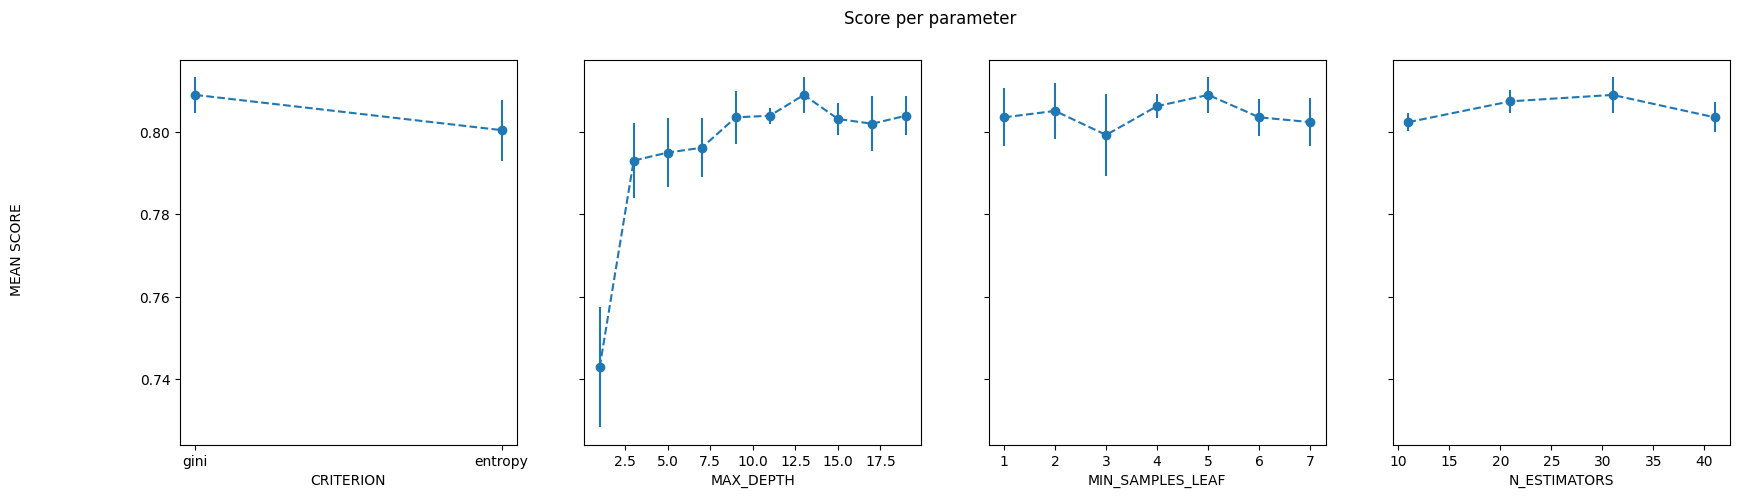

In [20]:
plot_search_results(grid)

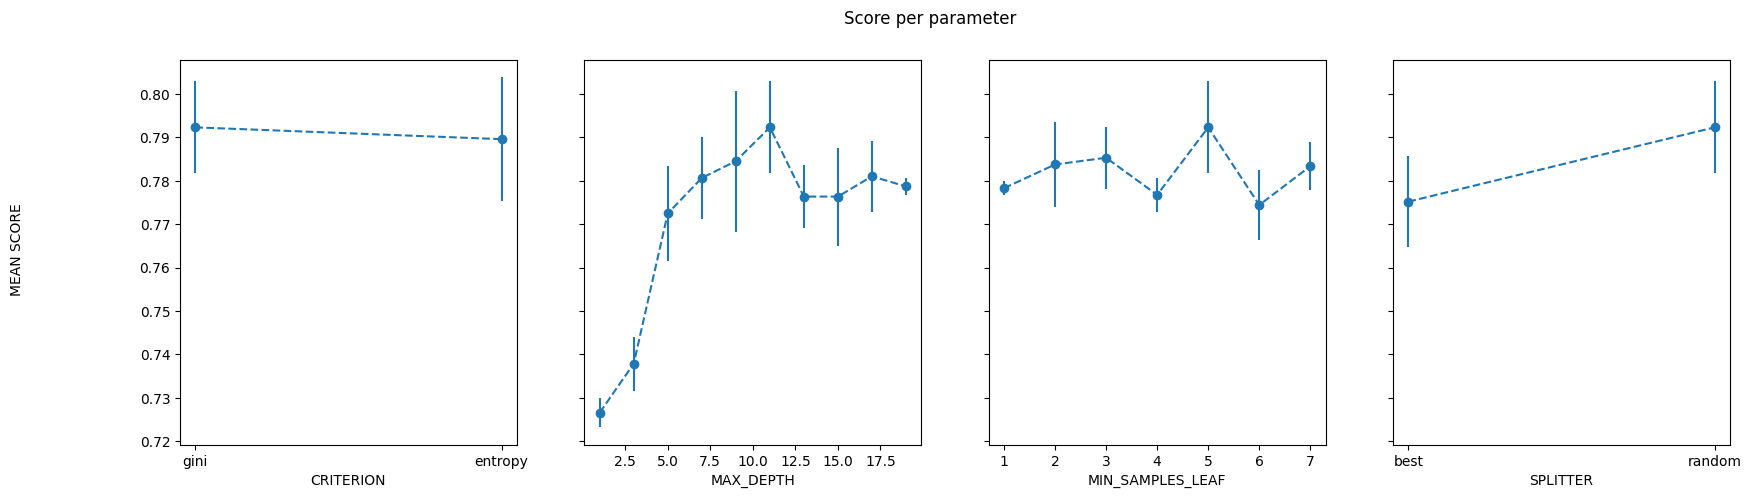

In [21]:
plot_search_results(grid_tree)

In [22]:
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 5,
 'splitter': 'random'}

In [23]:
result_tree = pd.DataFrame(grid_tree.cv_results_)
result_tree.sort_values(by = 'mean_test_score' , ascending = False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
79        0.001341      0.000466         0.001023    3.343664e-05   
14        0.003370      0.000445         0.001000    4.052337e-07   
22        0.001998      0.000002         0.001002    2.063235e-06   
18        0.002888      0.000159         0.001005    2.727668e-06   
16        0.002332      0.000471         0.001008    1.049824e-05   
..             ...           ...              ...             ...   
1         0.001967      0.000047         0.001010    1.322358e-05   
7         0.001584      0.000426         0.001333    4.713142e-04   
9         0.001737      0.000528         0.001062    8.620523e-05   
11        0.001332      0.000472         0.001029    3.831400e-05   
130       0.006374      0.000457         0.002006    8.326086e-06   

    param_criterion param_max_depth param_min_samples_leaf param_splitter  \
79             gini              11                      5         random   
14             gini               3                      1           best   
22             gini               3                      5           best   
18             gini               3                      3           best   
16             gini               3                      2           best   
..              ...             ...                    ...            ...   
1              gini               1                      1         random   
7              gini               1                      4         random   
9              gini               1                      5         random   
11             gini               1                      6         random   
130            gini              19                      3           best   

                                                params  split0_test_score  \
79   {'criterion': 'gini', 'max_depth': 11, 'min_sa...           0.778296   
14   {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.800467   
22   {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.800467   
18   {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.800467   
16   {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.800467   
..                                                 ...                ...   
1    {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.726954   
7    {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.726954   
9    {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.726954   
11   {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.726954   
130  {'criterion': 'gini', 'max_depth': 19, 'min_sa...           0.735123   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
79            0.794632           0.803967         0.792299        0.010609   
14            0.777130           0.793466         0.790354        0.009778   
22            0.777130           0.793466         0.790354        0.009778   
18            0.777130           0.793466         0.790354        0.009778   
16            0.777130           0.793466         0.790354        0.009778   
..                 ...                ...              ...             ...   
1             0.730455           0.722287         0.726566        0.003346   
7             0.730455           0.722287         0.726566        0.003346   
9             0.730455           0.722287         0.726566        0.003346   
11            0.730455           0.722287         0.726566        0.003346   
130           0.715286           0.728121         0.726177        0.008214   

     rank_test_score  
79                 1  
14                 2  
22                 2  
18                 2  
16                 2  
..               ...  
1                266  
7                266  
9                266  
11               266  
130              280  

[280 rows x 15 columns]

вывод по деревьям: деревья менее точные,но куда быстрее 
<br>а вот здесь уже интереснее , param_max_depth уменьшился по сравнению с лесом , это из-за переобучения , лучшее значение этого параметра = 7 , худшее = 1
<br>param_criterion в отличие от леса , здесь entropy в лучших значениях тоже присутствует , тоесть от param_criterion не так сильно зависит , как в лесу (забыл отметить в лесу)
<br>ну и param_splitter best лучше чем random , ничего удивительного 
<br>лучший показатель точности 0.800467 , не плохо , но ожидаемо хуже чем у леса 
<br>худший показатель точности 0.734734 , хуже чем у леса , но уже не сильно , всё равно лучше чем гадать


In [24]:
model_logistic = LogisticRegression(random_state=5)

In [25]:
parametrs = { 'penalty': ['l1', 'l2', 'elasticnet'],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'max_iter': range (1000,10000, 1000) }

In [26]:
warnings.filterwarnings("ignore")

In [27]:
grid_logistic = GridSearchCV(model_logistic, parametrs, cv=3)
grid_logistic.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=5),
             param_grid={'max_iter': range(1000, 10000, 1000),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

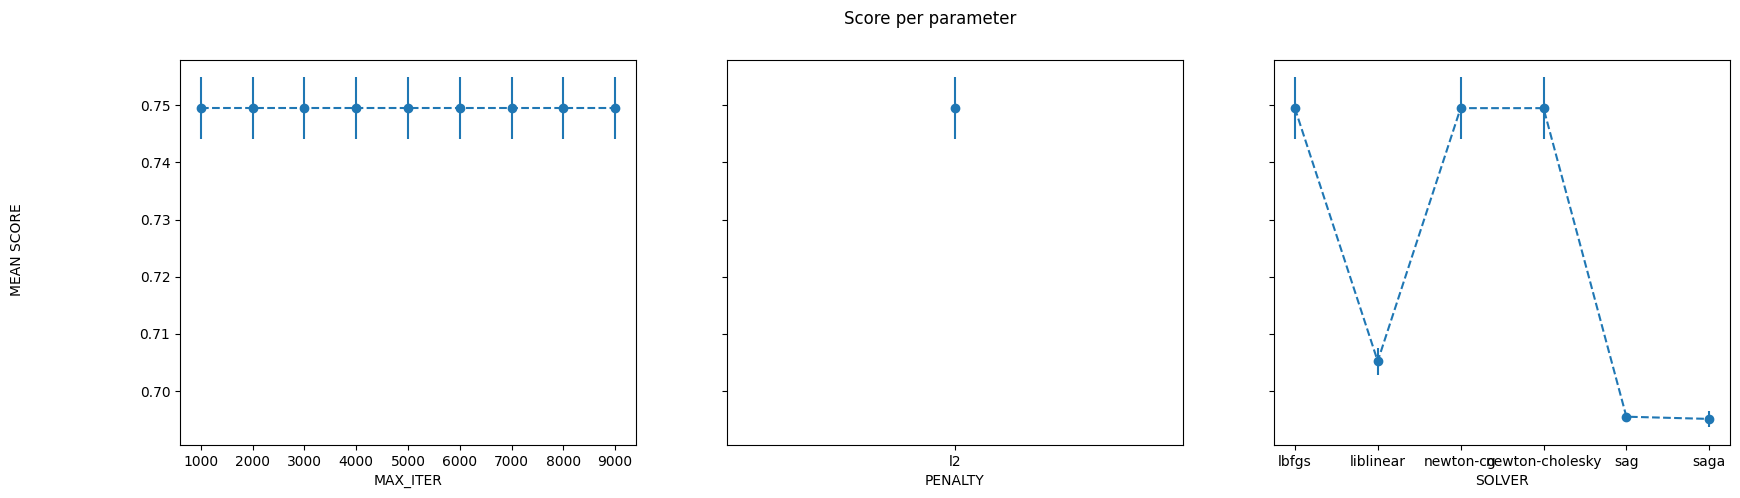

In [28]:
plot_search_results(grid_logistic)

In [29]:
grid_logistic.best_params_

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

In [30]:
result_logistic = pd.DataFrame(grid_logistic.cv_results_)
result_logistic = result_logistic.dropna()
result_logistic.sort_values(by = 'mean_test_score' , ascending = False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
80        0.037603      0.005244         0.001964        0.000055   
132       0.008699      0.000377         0.001358        0.000506   
81        0.002724      0.000390         0.001000        0.000001   
63        0.003338      0.000468         0.001022        0.000030   
62        0.037895      0.005774         0.001675        0.000463   
..             ...           ...              ...             ...   
29        0.238424      0.001185         0.002001        0.000001   
23        0.258133      0.002862         0.001446        0.000416   
10        0.118674      0.015579         0.001335        0.000474   
11        0.121604      0.003421         0.000998        0.000003   
5         0.130961      0.001567         0.001671        0.000463   

    param_max_iter param_penalty     param_solver  \
80            5000            l2        newton-cg   
132           8000            l2            lbfgs   
81            5000            l2  newton-cholesky   
63            4000            l2  newton-cholesky   
62            4000            l2        newton-cg   
..             ...           ...              ...   
29            2000            l2             saga   
23            2000            l1             saga   
10            1000            l2              sag   
11            1000            l2             saga   
5             1000            l1             saga   

                                                params  split0_test_score  \
80   {'max_iter': 5000, 'penalty': 'l2', 'solver': ...           0.751459   
132  {'max_iter': 8000, 'penalty': 'l2', 'solver': ...           0.751459   
81   {'max_iter': 5000, 'penalty': 'l2', 'solver': ...           0.751459   
63   {'max_iter': 4000, 'penalty': 'l2', 'solver': ...           0.751459   
62   {'max_iter': 4000, 'penalty': 'l2', 'solver': ...           0.751459   
..                                                 ...                ...   
29   {'max_iter': 2000, 'penalty': 'l2', 'solver': ...           0.695449   
23   {'max_iter': 2000, 'penalty': 'l1', 'solver': ...           0.695449   
10   {'max_iter': 1000, 'penalty': 'l2', 'solver': ...           0.695449   
11   {'max_iter': 1000, 'penalty': 'l2', 'solver': ...           0.696616   
5    {'max_iter': 1000, 'penalty': 'l1', 'solver': ...           0.696616   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
80            0.742124           0.754959         0.749514        0.005417   
132           0.742124           0.754959         0.749514        0.005417   
81            0.742124           0.754959         0.749514        0.005417   
63            0.742124           0.754959         0.749514        0.005417   
62            0.742124           0.754959         0.749514        0.005417   
..                 ...                ...              ...             ...   
29            0.695449           0.695449         0.695449        0.000000   
23            0.695449           0.695449         0.695449        0.000000   
10            0.695449           0.695449         0.695449        0.000000   
11            0.693116           0.695449         0.695060        0.001455   
5             0.693116           0.695449         0.695060        0.001455   

     rank_test_score  
80                 1  
132                1  
81                 1  
63                 1  
62                 1  
..               ...  
29                68  
23                68  
10                68  
11                71  
5                 71  

[72 rows x 14 columns]

вывод по логистической регрессии: 
<br>либо я что-то сделал не так , либо у данного вида моделей ниже точность 
<br>в таком диапозоне итерации количество циклов не так сильно влияет , в лучших моделях есть и 1к и 9к(пробовал и 100к) итераций(но в худших количество итераций прям по минимуму (1к))
<br>значения заметно ниже чем у растительности


## Проверка моделей на тестовой выборке

In [31]:
best2_model = grid.best_estimator_
ans = best2_model.predict(features_test)
accuracy = accuracy_score(target_test,ans)
accuracy

0.7869362363919129

0.78 , Жалко ухудшелся показатель , но что уж поделать)

## Проверка на адекватность

по логики у нас должно получиться что-то в районе 0.5 при рандоме

In [32]:
data = np.random.randint(0, 2, size=len(ans))
df = pd.DataFrame(data, columns=['random_numbers'])
accuracy = accuracy_score(df,ans)
accuracy

0.4681181959564541

ну вот да , что-то в районе 0.5 , тоесть даже самые худшие модели будут лучше рандома , но её нельзя назвать baseline 

In [34]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train,target_train)
answ = dummy_clf.predict(features_test)
accuracy = dummy_clf.score(answ, target_test)
accuracy

0.6936236391912908

проверка на адекватность пройдена 

<b>вывод:</b>
<br>основная информация с которой мы работали это столбец is_ultra (целевая переменная) , также задействовали столбцы minutes,messages,mb_used
<br>итог эксперементов с моделями:на данный момент лес показался оптимальной моделью , но он слишком долгий в работе 
<br>линеная регрессия , пока не расскрыла свой потенциал 